# Association between Fertility & Local Municipal Characteristics in Denmark 

## Imports

In [1]:
#TODO: comments for libraries
import geopandas as gpd # for geospatial data handling
import pandas as pd
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import matplotlib as mpl # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
import numpy as np
import scipy
from scipy import stats
from sklearn import linear_model # for multiple regression analysis 
import statsmodels.api as sm # for multiple regression analysis 
import esda
from splot.libpysal import plot_spatial_weights
from pysal.lib import weights
from sklearn import cluster
from sklearn.preprocessing import robust_scale

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

C:\Users\sutov\AppData\Local\Temp\ipykernel_16884\598501956.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd # for geospatial data handling


## Load the Data

Load the data extracts from DenmarkStatistik (process the data) and merge with geometries of municipalities in Denmark to a geo dataframe.

In [5]:
# total fertility rate (TFR)
data_fer = pd.read_excel('Data/fertility_rates_by_municipality_2021.xlsx')
# education
data_edu = pd.read_excel('Data/Education_women_master_2021.xlsx')
# disposable income
data_inc = pd.read_excel('Data/Disposable_income_2021.xlsx')
# dwelings with CPR
data_dwe = pd.read_excel('Data/Dwellings_with_CPR_2021.xlsx')
# household wealth
data_wea = pd.read_excel('Data/Household_wealth_2021.xlsx')

## Data processing 

### Fertility

In [6]:
# FERTILITY RATE
data_fer.head()

,Unnamed: 0,2021
0,Copenhagen,1 563.9
1,Frederiksberg,1 787.8
2,Dragør,2 510.9
3,Tårnby,2 056.7
4,Albertslund,1 608.7


In [7]:
# replacing missing values with 0
data_fer = data_fer.replace('..', 0)
# removing spaces and convert numbers to float
data_fer[2021] = data_fer[2021].str.replace(' ', '').astype(float)
# replacing non-finite values with 0
data_fer[2021] = data_fer[2021].replace([np.inf, -np.inf, np.nan], 0)

In [8]:
# the total fertility rate is per 1000 women, so lets change so its easier to understand and round it
data_fer[2021] = round(data_fer[2021] / 1000, 2)

In [9]:
# change the name of the columnns
data_fer.rename(columns = {'Unnamed: 0':'municipality_nm', 2021:'TFR'}, inplace = True)

In [ ]:
# change name to the same language
data_fer['municipality_nm'] = data_fer['municipality_nm'].replace('Copenhagen', 'København')

In [10]:
data_fer.head()

,municipality_nm,TFR
0,Copenhagen,1.56
1,Frederiksberg,1.79
2,Dragør,2.51
3,Tårnby,2.06
4,Albertslund,1.61


### Education

In [11]:
data_edu.head()

,2021,I alt (15-19 år),15-19 år,I alt (20-24 år),20-24 år,I alt (25-29 år),25-29 år,I alt (30-34 år),30-34 år,I alt (35-39 år),35-39 år
0,København,13 267,0,37 149,552,46 656,14 161,35 547,16 102,23 775,9 644
1,Frederiksberg,2 306,0,5 164,74,5 697,2 092,4 442,2 307,3 334,1 594
2,Dragør,429,0,172,1,176,20,309,94,418,134
3,Tårnby,1 189,0,865,5,904,94,1 248,255,1 388,298
4,Albertslund,818,0,952,9,867,97,839,119,785,127


In [12]:
# deal with type (to float)
columns_to_process = data_edu.columns[1:]
for column in columns_to_process:
    data_edu[column] = data_edu[column].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)


In [13]:
# sum all 'I alt' and sum all age groups and then take the percentage i.e. how many women in perc (age 15-39) have master or above and round it
data_edu['Sum_alt']=data_edu.iloc[:,[1,3,5,7,9]].sum(axis=1)
data_edu['Sum_master']=data_edu.iloc[:,[2,4,6,8,10]].sum(axis=1)
data_edu['master_perc'] = round(data_edu['Sum_master'] * 100 / data_edu['Sum_alt'], 2)

In [14]:
data_edu.rename(columns = {2021:'municipality_nm'}, inplace = True)

In [15]:
data_edu.head()

,municipality_nm,I alt (15-19 år),15-19 år,I alt (20-24 år),20-24 år,I alt (25-29 år),25-29 år,I alt (30-34 år),30-34 år,I alt (35-39 år),35-39 år,Sum_alt,Sum_master,master_perc
0,København,13267.0,0,37149.0,552,46656.0,14161.0,35547.0,16102.0,23775.0,9644.0,156394.0,40459.0,25.87
1,Frederiksberg,2306.0,0,5164.0,74,5697.0,2092.0,4442.0,2307.0,3334.0,1594.0,20943.0,6067.0,28.97
2,Dragør,429.0,0,172.0,1,176.0,20.0,309.0,94.0,418.0,134.0,1504.0,249.0,16.56
3,Tårnby,1189.0,0,865.0,5,904.0,94.0,1248.0,255.0,1388.0,298.0,5594.0,652.0,11.66
4,Albertslund,818.0,0,952.0,9,867.0,97.0,839.0,119.0,785.0,127.0,4261.0,352.0,8.26


### disposable income


In [16]:
# disposable income (average for men and women)
data_inc

,Unnamed: 0,2021
0,København,263 154
1,Frederiksberg,319 321
2,Dragør,350 841
3,Tårnby,275 721
4,Albertslund,230 832
...,...,...
93,Morsø,229 968
94,Rebild,270 439
95,Thisted,241 755
96,Vesthimmerlands,244 219


In [17]:
data_inc[2021] = data_inc[2021].str.replace(' ', '').astype(float)

In [18]:
# rename
data_inc.rename(columns = {'Unnamed: 0':'municipality_nm', 2021:'disp_income_avg_k'}, inplace = True)

In [19]:
# show in thousands and round the number
data_inc['disp_income_avg_k'] = round(data_inc['disp_income_avg_k']/1000, 2)

In [20]:
data_inc.head()

,municipality_nm,disp_income_avg_k
0,København,263.15
1,Frederiksberg,319.32
2,Dragør,350.84
3,Tårnby,275.72
4,Albertslund,230.83


### Dwellings

In [21]:
data_dwe

,2021,- 50 kvm,50-74 kvm,75-99 kvm,100-124 kvm,125-149 kvm,150-174 kvm,175 kvm og derover,Uoplyst
0,København,34 050,120 748,84 785,41 034,18 102,7 823,6 859,405
1,Frederiksberg,4 254,16 871,16 592,8 050,3 939,1 974,2 075,28
2,Dragør,172,694,1 074,1 043,1 372,910,832,7
3,Tårnby,1 187,4 472,5 443,3 139,2 494,1 398,715,7
4,Albertslund,1 899,1 639,3 599,3 027,1 322,648,236,2
...,...,...,...,...,...,...,...,...,...
94,Morsø,254,1 415,1 570,1 643,1 683,1 323,2 060,4
95,Rebild,192,980,1 821,2 106,2 238,2 259,3 430,26
96,Thisted,459,2 298,3 601,3 286,3 307,3 015,4 543,3
97,Vesthimmerlands,454,1 756,2 999,2 904,3 024,2 479,3 731,8


In [22]:
# square meters of dwelling per household in each municipality, 
# but we are gonna make a new variable - perc. of people in the municipality with the dweling more than 74 square meters. The missing
# data will be removed (Uoplyst):
data_dwe.drop(['Uoplyst'], inplace = True, axis = 1)

In [23]:
# deal with type (to float)
columns_to_process = data_dwe.columns[1:]
for column in columns_to_process:
    data_dwe[column] = data_dwe[column].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)

In [24]:
# sum all 'I alt' and sum all age groups and then take the percentage i.e. how many women in perc (age 15-39) have master or above
data_dwe['Sum_total'] = data_dwe.iloc[:,1:].sum(axis=1)
data_dwe['Sum_more_than_74'] = data_dwe.iloc[:,3:7].sum(axis=1)
data_dwe['dwelling_above_74_perc'] = round(data_dwe['Sum_more_than_74'] * 100 / data_dwe['Sum_total'], 2)

In [25]:
# rename
data_dwe.rename(columns = {2021:'municipality_nm'}, inplace = True)

In [26]:
data_dwe

,municipality_nm,- 50 kvm,50-74 kvm,75-99 kvm,100-124 kvm,125-149 kvm,150-174 kvm,175 kvm og derover,Sum_total,Sum_more_than_74,dwelling_above_74_perc
0,København,34050.0,120748.0,84785.0,41034.0,18102.0,7823.0,6859.0,313401.0,151744.0,48.42
1,Frederiksberg,4254.0,16871.0,16592.0,8050.0,3939.0,1974.0,2075.0,53755.0,30555.0,56.84
2,Dragør,172.0,694.0,1074.0,1043.0,1372.0,910.0,832.0,6097.0,4399.0,72.15
3,Tårnby,1187.0,4472.0,5443.0,3139.0,2494.0,1398.0,715.0,18848.0,12474.0,66.18
4,Albertslund,1899.0,1639.0,3599.0,3027.0,1322.0,648.0,236.0,12370.0,8596.0,69.49
...,...,...,...,...,...,...,...,...,...,...,...
94,Morsø,254.0,1415.0,1570.0,1643.0,1683.0,1323.0,2060.0,9948.0,6219.0,62.52
95,Rebild,192.0,980.0,1821.0,2106.0,2238.0,2259.0,3430.0,13026.0,8424.0,64.67
96,Thisted,459.0,2298.0,3601.0,3286.0,3307.0,3015.0,4543.0,20509.0,13209.0,64.41
97,Vesthimmerlands,454.0,1756.0,2999.0,2904.0,3024.0,2479.0,3731.0,17347.0,11406.0,65.75


### wealth

In [27]:
data_wea

,Unnamed: 0,2021
0,København,3 629 877
1,Frederiksberg,4 487 733
2,Dragør,5 105 646
3,Tårnby,3 408 593
4,Albertslund,3 088 083
...,...,...
93,Morsø,1 903 637
94,Rebild,2 711 788
95,Thisted,2 119 288
96,Vesthimmerlands,2 261 126


In [28]:
data_wea[2021] = data_wea[2021].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)


In [29]:
# rename
data_wea.rename(columns = {'Unnamed: 0':'municipality_nm', 2021:'household_wealth_avg_k'}, inplace = True)

In [30]:
# show in thousands and round the number
data_wea['household_wealth_avg_k'] = round(data_wea['household_wealth_avg_k']/1000, 2)

### create a final dataset

In [31]:
geometries = gpd.read_file('Data/municipalities_dk.gpkg')

In [32]:
data_fer.head() # all
#data_edu.head() # municipality_nm and master_perc
#data_inc.head() # all
#data_dwe.head() # municipality_nm and dwelling_more_than_74_sq_perc
# data_wea.head() # all

,municipality_nm,TFR
0,Copenhagen,1.56
1,Frederiksberg,1.79
2,Dragør,2.51
3,Tårnby,2.06
4,Albertslund,1.61


In [34]:
# check if data is the same size (lenght)
print(data_fer.shape)
print(data_edu.shape)
print(data_dwe.shape)
print(data_fer.shape)
print(data_wea.shape)

(99, 2)
(99, 14)
(99, 11)
(99, 2)
(98, 2)


In [35]:
data_edu = data_edu[['municipality_nm', 'master_perc']]
data_dwe = data_dwe[['municipality_nm', 'dwelling_above_74_perc']]

In [36]:
# Merge the data frames based on the 'municipality_nm' column using left join
merged_df = pd.merge(data_fer, data_edu, on='municipality_nm', how='left')
merged_df = pd.merge(merged_df, data_inc, on='municipality_nm', how='left')
merged_df = pd.merge(merged_df, data_dwe, on='municipality_nm', how='left')
merged_df = pd.merge(merged_df, data_wea, on='municipality_nm', how='left')

In [37]:
# Find rows with null values
null_rows = merged_df[merged_df.isnull().any(axis=1)]

print(null_rows)

   municipality_nm  TFR  master_perc  disp_income_avg_k  \
29     Christiansø  0.0         12.5                NaN   

    dwelling_above_74_perc  household_wealth_avg_k  
29                     NaN                     NaN  


In [38]:
# Drop Christiansø as it is not a municipality 
merged_df = merged_df.drop(merged_df[merged_df['municipality_nm'] == 'Christiansø'].index)

In [39]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 98
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   municipality_nm         98 non-null     object 
 1   TFR                     98 non-null     float64
 2   master_perc             98 non-null     float64
 3   disp_income_avg_k       98 non-null     float64
 4   dwelling_above_74_perc  98 non-null     float64
 5   household_wealth_avg_k  98 non-null     float64
dtypes: float64(5), object(1)
memory usage: 5.4+ KB


In [40]:
geometries = geometries.rename(columns={'navn': 'municipality_nm'}) #added

In [41]:
data = merged_df.merge(geometries, on='municipality_nm')

In [42]:
data.shape

(98, 10)

In [43]:
data.head()

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,kommunekode,region,municipal_id,geometry
0,København,1.56,25.87,263.15,48.42,3629.88,0101,NaN,101,"MULTIPOLYGON (((723090.010 6171801.780, 723090..."
1,Frederiksberg,1.79,28.97,319.32,56.84,4487.73,0147,NaN,147,"MULTIPOLYGON (((722290.770 6177984.800, 722299..."
2,Dragør,2.51,16.56,350.84,72.15,5105.65,0155,NaN,155,"MULTIPOLYGON (((729575.650 6168529.720, 729555..."
3,Tårnby,2.06,11.66,275.72,66.18,3408.59,0185,NaN,185,"MULTIPOLYGON (((729600.300 6172549.660, 729596..."
4,Albertslund,1.61,8.26,230.83,69.49,3088.08,0165,NaN,165,"MULTIPOLYGON (((711377.280 6178342.550, 711352..."


In [44]:
# drop those whith TFR = 0, since there is no data about fertility and they become outliers, also they are all islands
data = data[data['TFR'] != 0]

In [45]:
data.drop(['region', 'kommunekode'], axis=1, inplace=True)

In [46]:
data.shape

(94, 8)

In [47]:
data.to_excel('data.xlsx', index=False)

In [48]:
gdf = gpd.GeoDataFrame(data, geometry=data.geometry, crs = 'EPSG:25832') #added

In [49]:
gdf.head()

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,municipal_id,geometry
0,København,1.56,25.87,263.15,48.42,3629.88,101,"MULTIPOLYGON (((723090.010 6171801.780, 723090..."
1,Frederiksberg,1.79,28.97,319.32,56.84,4487.73,147,"MULTIPOLYGON (((722290.770 6177984.800, 722299..."
2,Dragør,2.51,16.56,350.84,72.15,5105.65,155,"MULTIPOLYGON (((729575.650 6168529.720, 729555..."
3,Tårnby,2.06,11.66,275.72,66.18,3408.59,185,"MULTIPOLYGON (((729600.300 6172549.660, 729596..."
4,Albertslund,1.61,8.26,230.83,69.49,3088.08,165,"MULTIPOLYGON (((711377.280 6178342.550, 711352..."


In [50]:
# save the GeoDataFrame to a GeoJSON file
gdf.to_file('Data/gdf.geojson', driver='GeoJSON')

### EDA

In [73]:
data.head()

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,municipal_id,geometry
0,København,1.56,25.87,263.15,48.42,3629.88,101,"MULTIPOLYGON (((723090.010 6171801.780, 723090..."
1,Frederiksberg,1.79,28.97,319.32,56.84,4487.73,147,"MULTIPOLYGON (((722290.770 6177984.800, 722299..."
2,Dragør,2.51,16.56,350.84,72.15,5105.65,155,"MULTIPOLYGON (((729575.650 6168529.720, 729555..."
3,Tårnby,2.06,11.66,275.72,66.18,3408.59,185,"MULTIPOLYGON (((729600.300 6172549.660, 729596..."
4,Albertslund,1.61,8.26,230.83,69.49,3088.08,165,"MULTIPOLYGON (((711377.280 6178342.550, 711352..."


In [74]:
characteristics = ['TFR','master_perc', 'disp_income_avg_k',
       'dwelling_above_74_perc', 'household_wealth_avg_k']

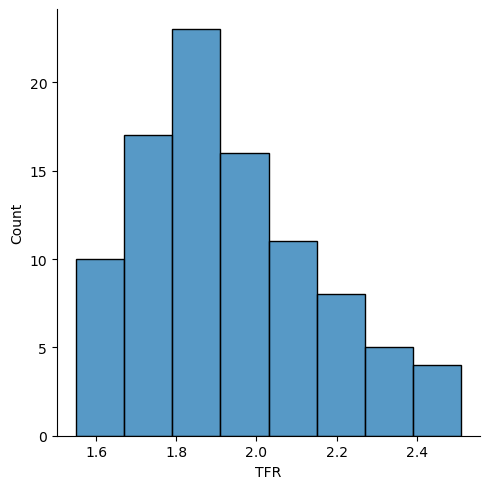

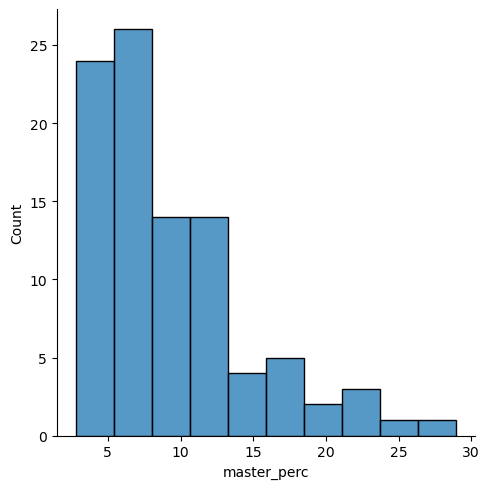

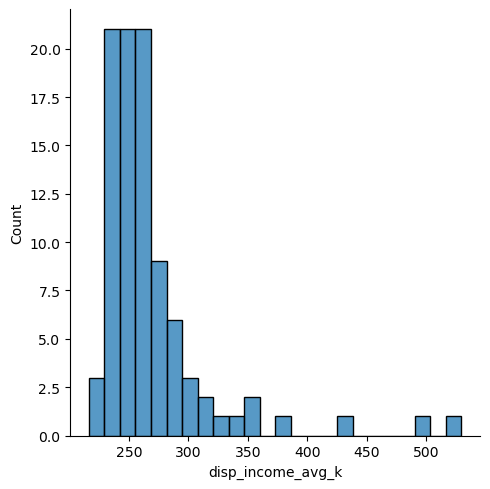

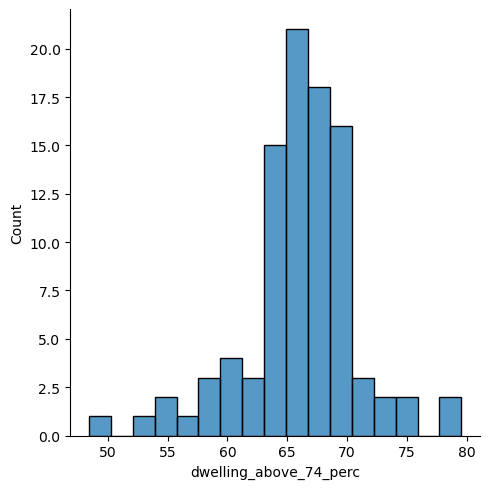

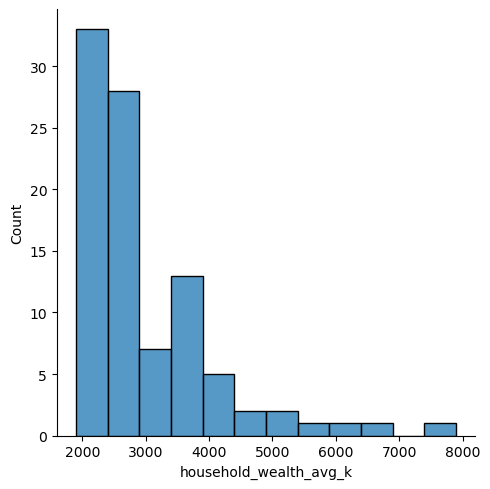

In [77]:
# Show distributions for categorical variables
for feature in characteristics:
    sns.displot(data, x=feature)

### Multiple regression analysis

1. Check the distribution of the data (if Gaussian -> linear regression; if not gaussian -> generalized linear regression; if not linear -> GAM)

https://analyticsindiamag.com/guide-to-generalized-additive-modelgam-to-improve-simple-linear-regression/

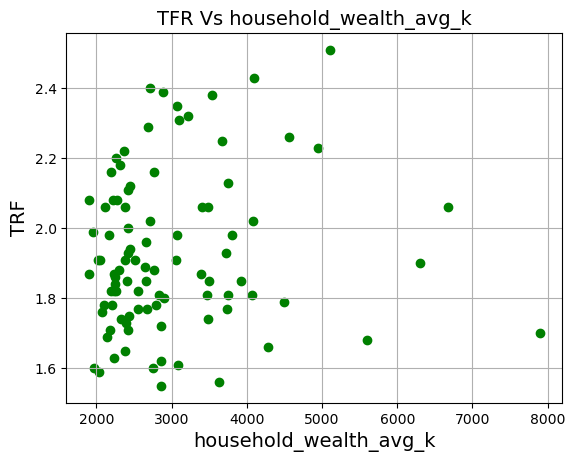

In [79]:
# TODO: figure out witch regression to use (multiple variables, cant check if gaussian)
# plot relationship between fertility rate and other variables 
plt.scatter(data['household_wealth_avg_k'], data['TFR'], color='green')
plt.title('TFR Vs household_wealth_avg_k', fontsize=14)
plt.xlabel('household_wealth_avg_k', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

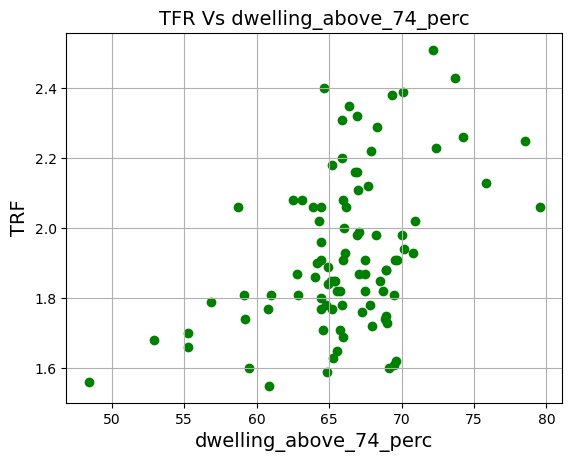

In [80]:
# plot relationship between fertility rate and other variables 
plt.scatter(data['dwelling_above_74_perc'], data['TFR'], color='green')
plt.title('TFR Vs dwelling_above_74_perc', fontsize=14)
plt.xlabel('dwelling_above_74_perc', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

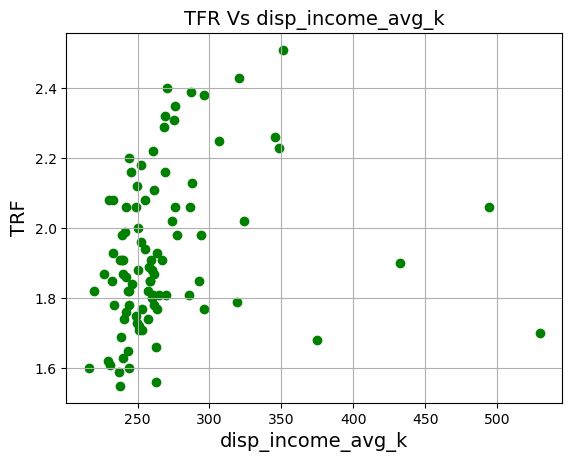

In [81]:
# plot relationship between fertility rate and other variables 
plt.scatter(data['disp_income_avg_k'], data['TFR'], color='green')
plt.title('TFR Vs disp_income_avg_k', fontsize=14)
plt.xlabel('disp_income_avg_k', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

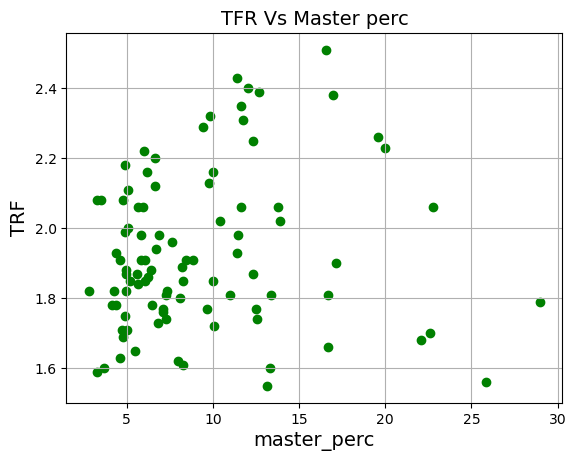

In [82]:
# plot relationship between fertility rate and other variables 
plt.scatter(data['master_perc'], data['TFR'], color='green')
plt.title('TFR Vs Master perc', fontsize=14)
plt.xlabel('master_perc', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

### Multiple linear regression analysis

In [83]:
characteristics

['TFR',
 'master_perc',
 'disp_income_avg_k',
 'dwelling_above_74_perc',
 'household_wealth_avg_k']

In [85]:
# Z-Score using scipy
data['TFR_st'] = stats.zscore(data['TFR'])
data['master_perc_st'] = stats.zscore(data['master_perc'])
data['disp_income_avg_k_st'] = stats.zscore(data['disp_income_avg_k'])
data['dwelling_above_74_perc_st'] = stats.zscore(data['dwelling_above_74_perc'])
data['household_wealth_avg_k_st'] = stats.zscore(data['household_wealth_avg_k'])

In [87]:
x = data[['master_perc_st', 'disp_income_avg_k_st', 'dwelling_above_74_perc_st', 'household_wealth_avg_k_st']]
y = data['TFR_st'] 

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)


Intercept: 
 -3.241513875893339e-15
Coefficients: 
 [ 0.48509585  0.82657783  0.53945595 -0.93987587]


In [89]:
# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 TFR_st   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     12.84
Date:                Mon, 22 May 2023   Prob (F-statistic):           2.70e-08
Time:                        08:03:37   Log-Likelihood:                -111.96
No. Observations:                  94   AIC:                             233.9
Df Residuals:                      89   BIC:                             246.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### Correlation

In [90]:
data[['TFR', 'master_perc_st', 'disp_income_avg_k_st', 'dwelling_above_74_perc_st', 'household_wealth_avg_k_st']].corr()

,TFR,master_perc_st,disp_income_avg_k_st,dwelling_above_74_perc_st,household_wealth_avg_k_st
TFR,1.000000,0.104829,0.218995,0.440265,0.109989
master_perc_st,0.104829,1.000000,0.723615,-0.355978,0.836659
disp_income_avg_k_st,0.218995,0.723615,1.000000,-0.165318,0.925041
dwelling_above_74_perc_st,0.440265,-0.355978,-0.165318,1.000000,-0.223584
household_wealth_avg_k_st,0.109989,0.836659,0.925041,-0.223584,1.000000


## Visualize data

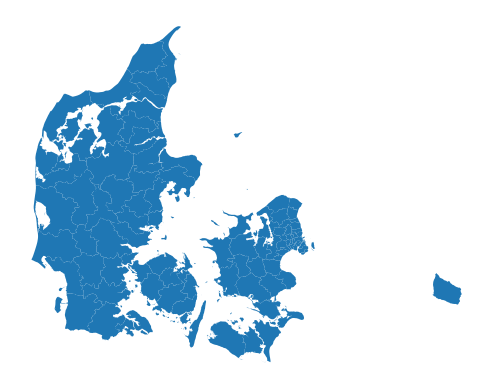

In [95]:
ax = gdf.plot(linewidth=0.3);
ax.set_axis_off()

In [96]:
cols = ['TFR', 
        'master_perc', 
        'disp_income_avg_k',
        'dwelling_above_74_perc',
        'household_wealth_avg_k']

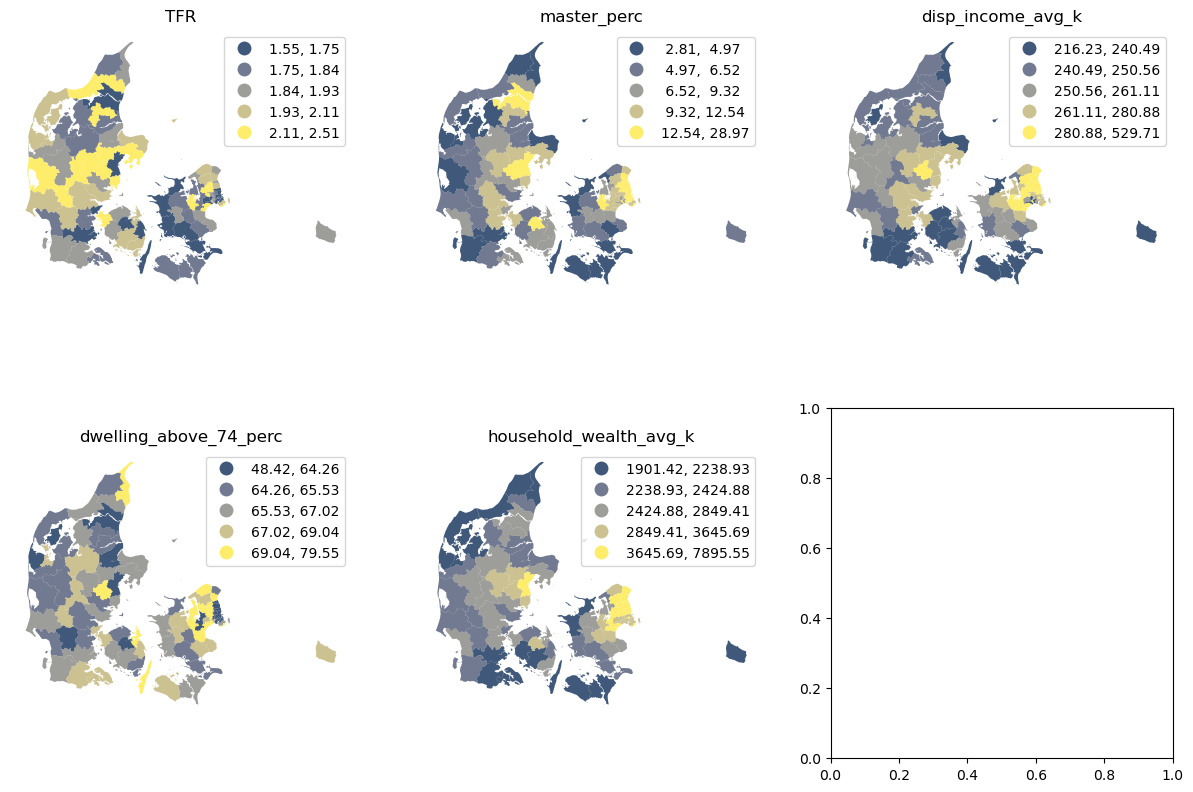

In [160]:
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Make the axes accessible with single indexing
axs = axs.flatten()


for i, col in enumerate(cols):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(
        column=col, 
        ax=ax, 
        scheme='Quantiles',
        linewidth=0.2, 
        cmap='cividis',
        alpha=0.75,
        legend=True,  # Add legend
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title 
    ax.set_title(col)
    
#plt.savefig('data_vis.png')

plt.show()

### Moran's I
Assesses the similarity or dissimilarity of attribute values between neighboring locations. 

In [148]:
# TODO: add aditional code queen or distance countinues values
w = weights.KNN.from_dataframe(gdf, k=4)
# Calculate Moran's I for each variable
mi_results = [esda.Moran(gdf[variable], w) for variable in cols]
# Structure results as a list of tuples
mi_results = [(variable, res.I, res.p_sim) for variable,res in zip(cols, mi_results)]
# Display on table
table = pd.DataFrame(
    mi_results,
    columns=['Variable', "Moran's I", 'P-value']
).set_index('Variable')
table
# if 0.001 is significant, 

,Moran's I,P-value
Variable,,
TFR,0.081158,0.084
master_perc,0.602031,0.001
disp_income_avg_k,0.466688,0.001
dwelling_above_74_perc,0.346594,0.001
household_wealth_avg_k,0.634103,0.001


TFR: it implies that neighboring areas tend to have slightly similar values, but the pattern is not very strong or pronounced. 
If we look at the 10 municipalities  with the highest fertility rate, we see that most of them are oplandskommuner, and then hovedstads kommuner:
Dragrør  - Hovedstadskommuner //
Solrød  - Hovedstadkommune //
Rebild - Oplandskommune //
Lejre - Oplandskommune //
Skanderborg - Oplandskommune //
Favrskov - Oplandskommune //
Odder - Oplandskommune //
Silkeborg - Provinsbykommune //
Middelfart - Oplandskommune //
Allerød - hovedstadkommune //

In [ ]:
# TODO: have code for the comment above

## Local spatial autocorrelation

In [ ]:
# TODO


## Clustering

### K-means

Using elbow method to find the optimal k

In [104]:
# scale data
elbow_df = gdf[['TFR', 'master_perc', 'disp_income_avg_k', 'dwelling_above_74_perc', 'household_wealth_avg_k']]
scaled_elbow_df = robust_scale(elbow_df)

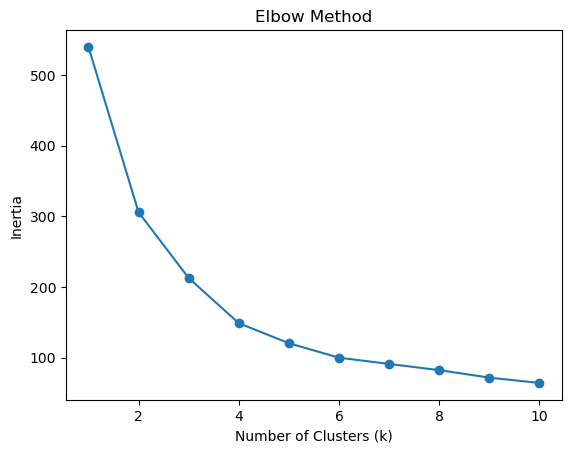

In [147]:
#Define a range of values for k
k_values = range(1, 11)
inertias = []

# Perform k-means clustering for each value of k
for k in k_values:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(scaled_elbow_df)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
#plt.savefig('ElbowMethod.png')
plt.show()

In [106]:
kmeans4 = cluster.KMeans(n_clusters=4, random_state=12345)

In [107]:
# scale data
for c in cols:
    gdf[c+'_scaled'] = robust_scale(gdf[c])

In [108]:
cluster_cols_scaled = [c+'_scaled' for c in cols]

In [109]:
# Run the clustering algorithm
k4cls = kmeans4.fit(gdf[cluster_cols_scaled])

In [110]:
k4cls.labels_

array([2, 2, 0, 1, 1, 1, 1, 3, 2, 2, 2, 2, 1, 1, 3, 2, 0, 0, 0, 0, 1, 0,
       1, 1, 2, 0, 3, 3, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2], dtype=int32)

In [111]:
# append to original data
gdf['k4cls'] = k4cls.labels_

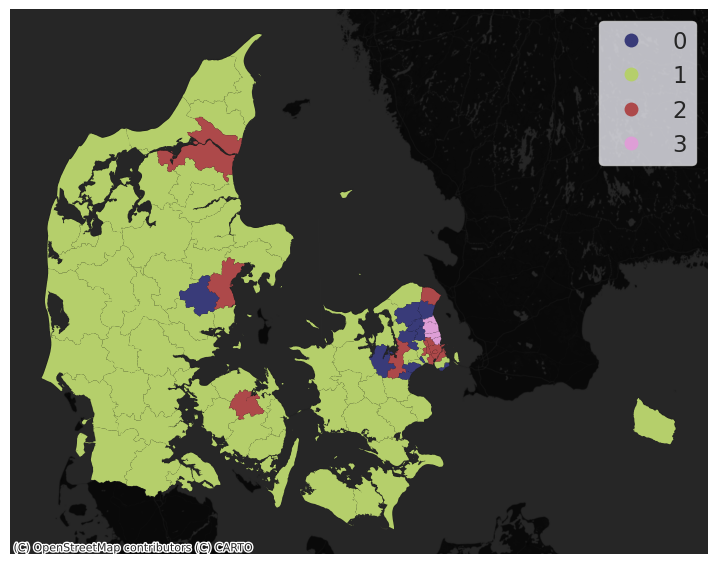

In [175]:
# Plot clusters 
f, ax = plt.subplots(1, figsize=(9, 9))

gdf.plot(
    column='k4cls', 
    categorical=True, 
    legend=True, 
    linewidth=0, 
    ax=ax, 
    cmap='tab20b'
)
# Remove axis
ax.set_axis_off()
# Add title
#plt.title('Need to find a title')

# Add basemap
cx.add_basemap(
    ax,
    crs=gdf.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels # can change this to something (white if thats better)
)
plt.savefig('Kmeanscluster.png')
# Display the map
plt.show()

In [162]:
# Count of municipalities is in each group 
k4sizes = gdf.groupby('k4cls').size()
k4sizes

k4cls
0    11
1    67
2    12
3     4
dtype: int64

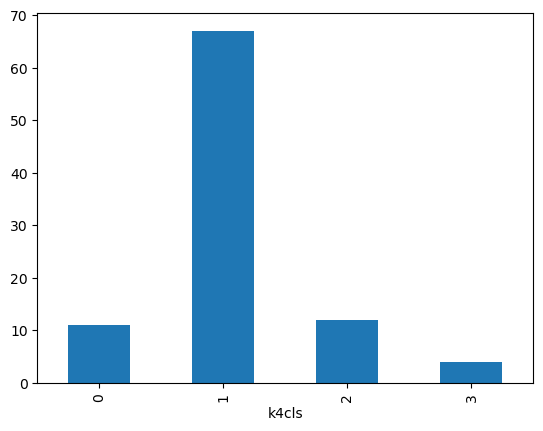

In [114]:
k4sizes.plot.bar();

In [ ]:
# TODO: print the municipalities for each cluster and TFR

In [116]:
# Calculate the mean by group
k4means = gdf.groupby('k4cls')[cols].mean()

k4means.T

k4cls,0,1,2,3
TFR,2.240000,1.917015,1.735000,1.8350
master_perc,14.400000,6.627463,15.530833,21.1475
disp_income_avg_k,313.378182,250.019701,270.630000,457.6975
dwelling_above_74_perc,73.177273,66.647463,59.329167,57.7625
household_wealth_avg_k,3990.347273,2493.341493,3652.367500,6617.1150


Draw the distributions of cluster members’ data:

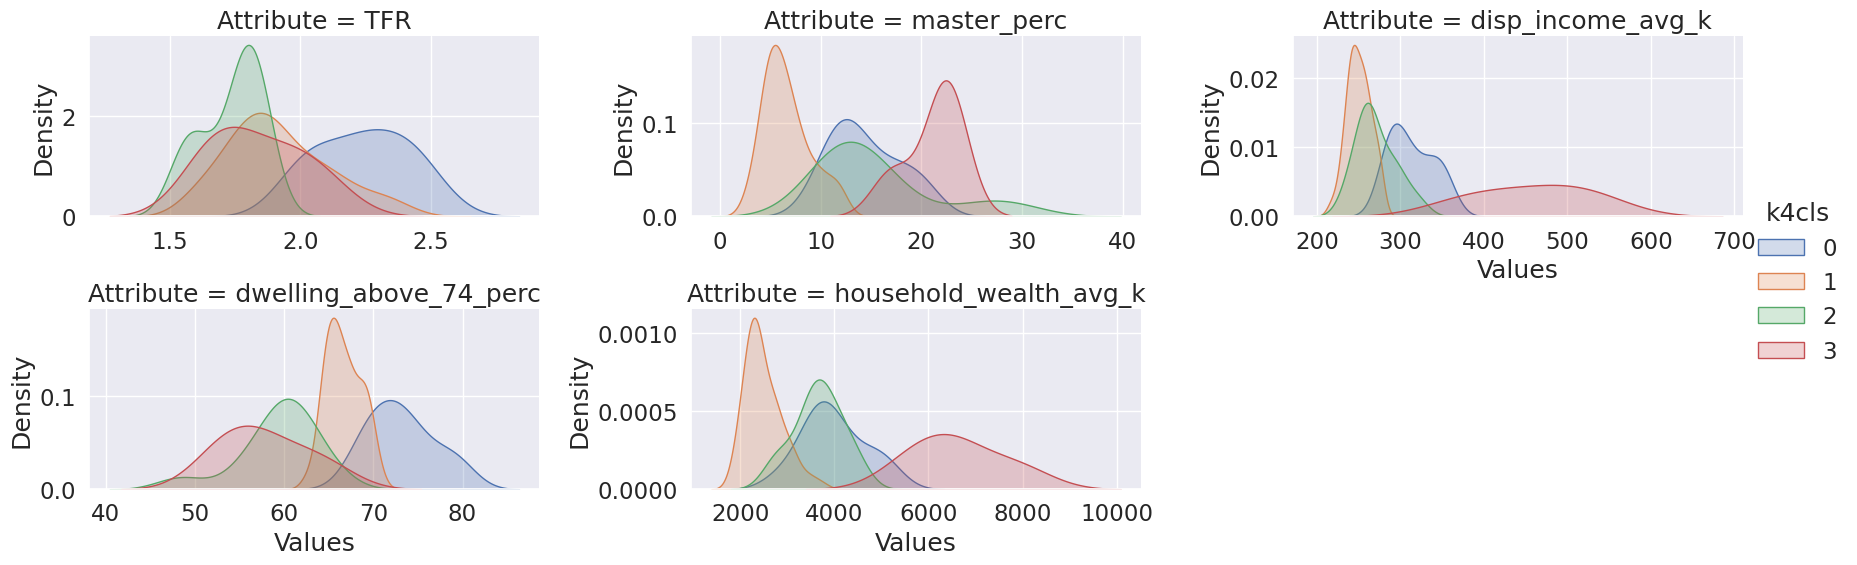

In [163]:
# Index on cluster ID
tidy_db = gdf.set_index('k4cls')
# Keep only variables used for clustering
tidy_db = tidy_db[cols]
# Stack column names into a column
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)



# Scale fonts 
sns.set(font_scale=1.5)
# Setup the facets
facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue='k4cls',
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)

facets.map(sns.kdeplot, "Values", fill=True,warn_singular=False).add_legend();

### Regionalization 

In [139]:
# TODO: change to queen or think if wa

# create spatial weight matrix
w = weights.KNN.from_dataframe(gdf,k=4,ids='municipal_id') #which k if best? 

# Alternative:
#w_queen = weights.Queen.from_dataframe(gdf, idVariable='municipal_id')


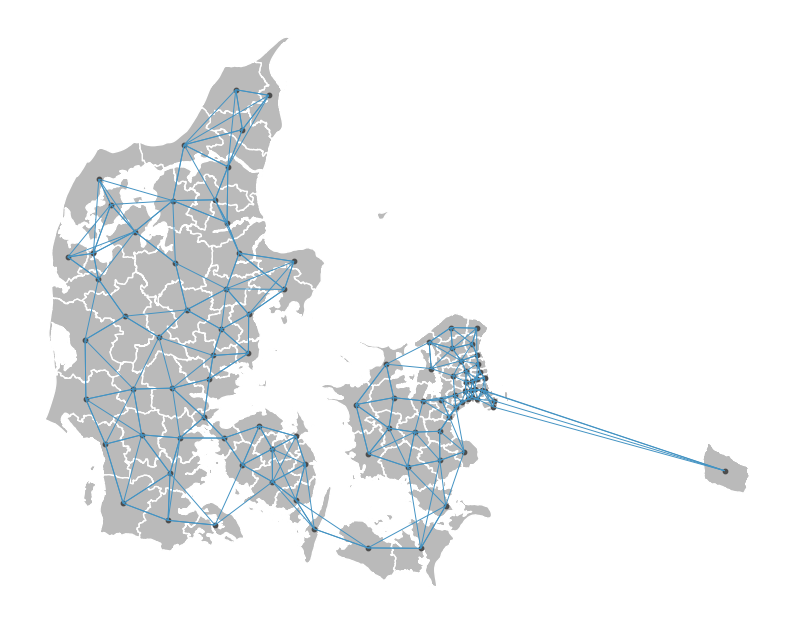

In [140]:
plot_spatial_weights(w, gdf, indexed_on='municipal_id');

In [165]:
# spatially-constrained version of the agglomerative algorithm

sagg13 = cluster.AgglomerativeClustering(n_clusters=8, connectivity=w.sparse)
sagg13

AgglomerativeClustering(connectivity=<94x94 sparse matrix of type '<class 'numpy.float64'>'
	with 376 stored elements in Compressed Sparse Row format>,
                        n_clusters=8)

In [166]:
# Run the clustering algorithm with scaled data
# TODO: how to scale data and why
sagg13cls = sagg13.fit(gdf[cluster_cols_scaled])

In [167]:
# add to dataframe
gdf['sagg13cls'] = sagg13cls.labels_

In [168]:
# Calculate the mean by group
sagg13_data = gdf.groupby('sagg13cls')[cols].mean()

sagg13_data.T

sagg13cls,0,1,2,3,4,5,6,7
TFR,2.184286,1.8350,1.805385,1.889123,2.098333,2.2525,2.51,1.675
master_perc,11.702857,21.1475,10.899231,6.297719,14.531667,11.9100,16.56,27.420
disp_income_avg_k,272.770000,457.6975,256.625385,248.664386,318.550000,295.5100,350.84,291.235
dwelling_above_74_perc,65.375714,57.7625,65.057692,66.186316,71.616667,74.7925,72.15,52.630
household_wealth_avg_k,3196.594286,6617.1150,3324.534615,2399.684386,4162.105000,3550.7750,5105.65,4058.805


In [171]:
# custom colormap to ensure uniform colors between plots and maps
colors = ["#a6cee3",
"#1f78b4",
#"#b2df8a",
"#33a02c",
"#fb9a99",
"#e31a1c",
"#fdbf6f",
#"#ff7f00",
#"#cab2d6",
"#6a3d9a",
#"#ffff99",
"#b15928"]

keys = list(range(0,12))

color_dict={}

for k, c in zip(keys, colors):
    color_dict[k] = c

vals = gdf.sagg13cls.unique()
vals.sort()
cmap = mpl.colors.ListedColormap([color_dict[b] for b in vals])

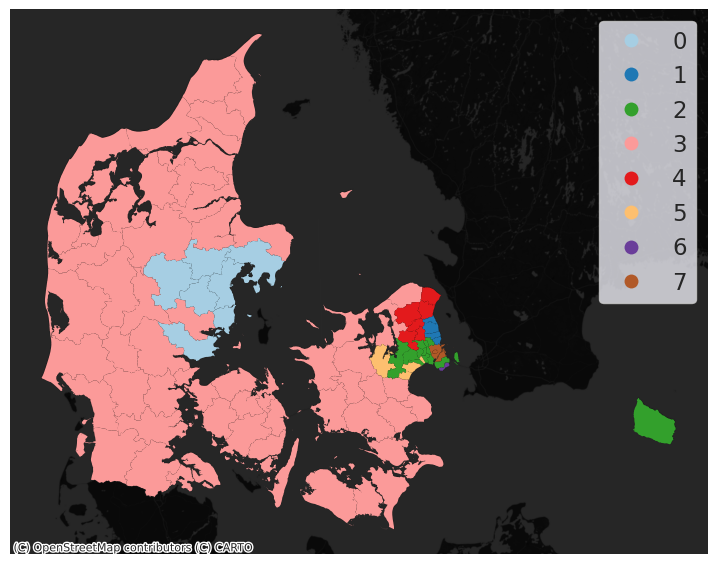

In [176]:
# Plot clusters 
f, ax = plt.subplots(1, figsize=(9,9))

gdf.plot(
    column='sagg13cls', categorical=True, legend=True, linewidth=0, cmap=cmap, ax=ax
)
# Remove axis
ax.set_axis_off()

# Add basemap
cx.add_basemap(
    ax,
    crs=gdf.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels 
)
plt.savefig('KmeansclusterReg.png')

# Display the map
plt.show()

Draw the distributions of cluster members’ data:

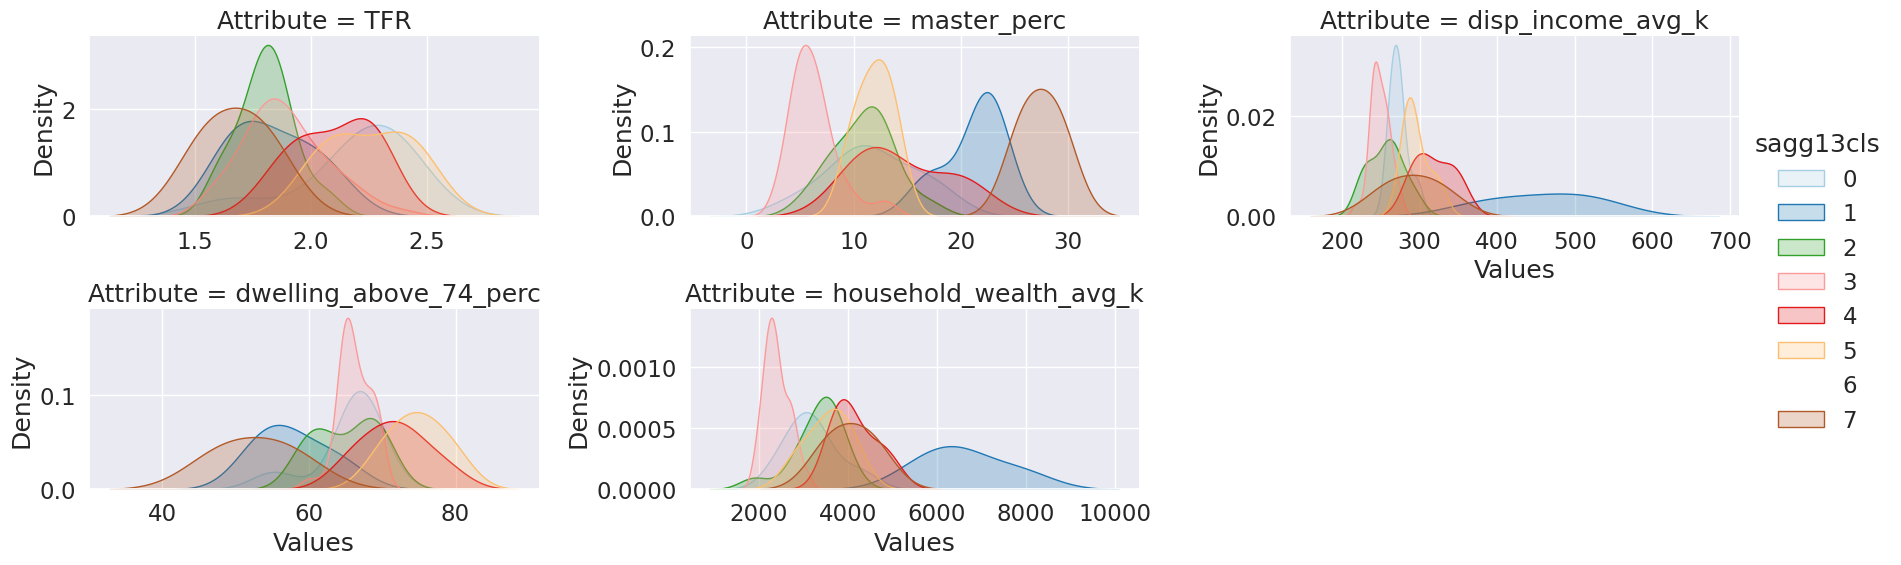

In [180]:
# Index on cluster ID
tidy_db = gdf.set_index('sagg13cls')
# Keep only variables used for clustering
tidy_db = tidy_db[cols]
# Stack column names into a column
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)

#sns.set(font_scale=1.5)

facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue='sagg13cls',
    sharey=False,
    sharex=False,
    aspect=2,
    palette= colors, #'tab20',
    col_wrap=3,
)

facets.map(sns.kdeplot, "Values", fill=True, warn_singular=False).add_legend();